# CNN-Vision Transformer Hybrid Model for Deepfake Detection

This notebook implements a hybrid deep learning architecture for detecting deepfakes in full face regions.

## Dataset Structure
- `CroppedFaces/original/` → Real images (label 0)
- `CroppedFaces/manipulated/` → Fake images (label 1)

## Instructions
1. Upload your dataset to Google Colab (or mount Google Drive)
2. Update the `data_dir` path in the Configuration cell if needed
3. Run all cells sequentially
4. Training will automatically save the best model


In [ ]:
# Install required packages (if not already installed)
%pip install torch torchvision tqdm scikit-learn pillow -q

# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA L4


In [ ]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from PIL import Image
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import json
from datetime import datetime
from typing import Tuple


## Model Architecture - Paper's Model C (Full Face)

Based on: "Deepfake detection using convolutional vision transformers and convolutional neural networks"

**Architecture**:
- Simple 2-layer CNN (32 filters, 3x3) for feature extraction
- Vision Transformer (patch_size=7, depth=6, dim=1024, heads=8) processes CNN features
- Global Average Pooling
- Dense classification layer


In [ ]:
# ============================================================================
# MODEL ARCHITECTURE - PAPER'S MODEL C
# ============================================================================

class MultiHeadSelfAttention(nn.Module):
    """Multi-Head Self-Attention mechanism"""
    def __init__(self, embed_dim: int = 1024, num_heads: int = 8, dropout: float = 0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape

        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)

        return x


class TransformerBlock(nn.Module):
    """Transformer encoder block"""
    def __init__(self, dim: int, heads: int, mlp_dim: int, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)

        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Pre-norm architecture
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class SimpleCNNModule(nn.Module):
    """
    Simple CNN Module as per paper's Model C
    Two Conv2D layers (32 filters, 3x3 kernel) + Max Pooling
    """
    def __init__(self, in_channels=3, out_channels=32):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.out_channels = out_channels

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.features(x)


class PaperViTModule(nn.Module):
    """
    Vision Transformer Module - processes CNN feature maps
    """
    def __init__(self, feature_size: int, patch_size: int = 7,
                 dim: int = 1024, depth: int = 6, heads: int = 8,
                 mlp_dim: int = 2048, dropout: float = 0.1):
        super().__init__()
        self.feature_size = feature_size
        self.patch_size = patch_size
        self.dim = dim
        self.depth = depth

        # Calculate number of patches
        self.n_patches = (feature_size // patch_size) ** 2

        # Patch embedding: convert patches to vectors
        self.patch_embed = nn.Conv2d(
            32, dim, kernel_size=patch_size, stride=patch_size
        )

        # Position embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, self.n_patches, dim))

        # Transformer encoder blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(dim, heads, mlp_dim, dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.shape[0]

        # Patch embedding: (B, 32, H, W) -> (B, dim, H', W')
        x = self.patch_embed(x)

        # Flatten spatial dimensions: (B, dim, H', W') -> (B, n_patches, dim)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, n_patches, dim)

        # Add position embedding
        x = x + self.pos_embed
        x = self.dropout(x)

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        return x  # (B, n_patches, dim)


class PaperModelC(nn.Module):
    """
    Model C from Paper: CNN-ViT for Full Face Detection
    Architecture matches the paper exactly
    """
    def __init__(
        self,
        img_size: int = 224,
        num_classes: int = 2,
        patch_size: int = 7,
        dim: int = 1024,
        depth: int = 6,
        heads: int = 8,
        mlp_dim: int = 2048,
        dropout: float = 0.1
    ):
        super().__init__()

        self.img_size = img_size

        # CNN Module (as per paper)
        self.cnn_module = SimpleCNNModule(in_channels=3, out_channels=32)

        # Calculate feature size after CNN (224 -> 112 after MaxPool)
        feature_size = img_size // 2

        # ViT Module (processes CNN features)
        self.vit_module = PaperViTModule(
            feature_size=feature_size,
            patch_size=patch_size,
            dim=dim,
            depth=depth,
            heads=heads,
            mlp_dim=mlp_dim,
            dropout=dropout
        )

        # Global Average Pooling (as per paper)
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Classification Head (Dense layer with Softmax)
        self.classifier = nn.Linear(dim, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # CNN feature extraction: (B, 3, 224, 224) -> (B, 32, 112, 112)
        cnn_features = self.cnn_module(x)

        # ViT processing: (B, 32, 112, 112) -> (B, n_patches, dim)
        vit_features = self.vit_module(cnn_features)  # (B, n_patches, dim)

        # Global Average Pooling: (B, n_patches, dim) -> (B, dim)
        vit_features = vit_features.transpose(1, 2)  # (B, dim, n_patches)
        pooled = self.global_pool(vit_features).squeeze(-1)  # (B, dim)

        # Classification: (B, dim) -> (B, num_classes)
        logits = self.classifier(pooled)

        return logits

print("✓ Model architecture defined successfully!")


✓ Model architecture defined successfully!


## Dataset and Data Loading


In [ ]:
# ============================================================================
# DATASET CLASS
# ============================================================================

class DeepfakeDataset(Dataset):
    """Dataset for deepfake detection"""
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform

        # Get all image paths
        real_dir = self.root_dir / 'original'
        fake_dir = self.root_dir / 'manipulated'

        real_images = list(real_dir.glob('*.jpg'))
        fake_images = list(fake_dir.glob('*.jpg'))

        # Create labels: 0 for real, 1 for fake
        self.images = real_images + fake_images
        self.labels = [0] * len(real_images) + [1] * len(fake_images)

        print(f"Found {len(real_images)} real images and {len(fake_images)} fake images")
        print(f"Label mapping: 0 = Real (from 'original' folder), 1 = Fake (from 'manipulated' folder)")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', (224, 224), color='black')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label


def get_data_loaders(data_dir, batch_size=16, val_split=0.2, test_split=0.1, num_workers=2):
    """Create train, validation, and test data loaders"""

    # Data augmentation for training
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Validation/test transforms (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create full dataset
    full_dataset = DeepfakeDataset(data_dir, transform=train_transform)

    # Split dataset
    total_size = len(full_dataset)
    test_size = int(total_size * test_split)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Update transforms for validation and test
    val_dataset.dataset.transform = val_transform
    test_dataset.dataset.transform = val_transform

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

print("✓ Dataset classes defined successfully!")


✓ Dataset classes defined successfully!


In [ ]:
# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def evaluate(model, data_loader, device, criterion=None):
    """Evaluate model on a dataset"""
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if criterion:
                loss = criterion(outputs, labels)
                total_loss += loss.item()

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    avg_loss = total_loss / len(data_loader) if criterion else None

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm.tolist(),
        'loss': avg_loss
    }


def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

print("✓ Training functions defined successfully!")


✓ Training functions defined successfully!


## Configuration

**Note**: If using Google Drive, uncomment the mount code below.


In [ ]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# If using Google Drive, uncomment and run this cell first:
from google.colab import drive
drive.mount('/content/drive')

# Configuration
config = {
    'data_dir': '/content/drive/MyDrive/CroppedFaces',  # Update this path if needed
    'batch_size': 64,  # Increased from 32 for better GPU utilization
    'num_epochs': 100,
    'learning_rate': 1e-4,
    'weight_decay': 1e-7,  # Paper uses 0.0000001
    'val_split': 0.2,
    'test_split': 0.1,
    'num_workers': 4, # Increased from 2 for faster data loading
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'save_dir': 'checkpoints',
    'model_name': 'paper_model_c',
    # Paper's Model C hyperparameters
    'patch_size': 7,
    'dim': 1024,
    'depth': 6,
    'heads': 8,
    'mlp_dim': 2048,
    'dropout': 0.3 # Increased dropout to mitigate overfitting
}

print("=" * 60)
print("CNN-ViT Hybrid Model - Training Configuration")
print("=" * 60)
print(f"Device: {config['device']}")
print(f"Batch size: {config['batch_size']}")
print(f"Learning rate: {config['learning_rate']}")
print(f"Number of epochs: {config['num_epochs']}")
print(f"Using Paper's Model C architecture")
print("=" * 60)

Mounted at /content/drive
CNN-ViT Hybrid Model - Training Configuration
Device: cuda
Batch size: 64
Learning rate: 0.0001
Number of epochs: 100
Using Paper's Model C architecture


## Load Dataset


In [ ]:
# Create save directory
os.makedirs(config['save_dir'], exist_ok=True)

# Create data loaders
print("\nLoading data...")
train_loader, val_loader, test_loader = get_data_loaders(
    config['data_dir'],
    batch_size=config['batch_size'],
    val_split=config['val_split'],
    test_split=config['test_split'],
    num_workers=config['num_workers']
)

print(f"\nDataset splits:")
print(f"  Train samples: {len(train_loader.dataset)}")
print(f"  Val samples: {len(val_loader.dataset)}")
print(f"  Test samples: {len(test_loader.dataset)}")



Loading data...
Found 13109 real images and 13346 fake images
Label mapping: 0 = Real (from 'original' folder), 1 = Fake (from 'manipulated' folder)

Dataset splits:
  Train samples: 18519
  Val samples: 5291
  Test samples: 2645


## Create Model


In [ ]:
# Create model - Paper's Model C architecture
print("\nCreating Paper's Model C (Full Face)...")
model = PaperModelC(
    img_size=224,
    num_classes=2,
    patch_size=config['patch_size'],
    dim=config['dim'],
    depth=config['depth'],
    heads=config['heads'],
    mlp_dim=config['mlp_dim'],
    dropout=0.1
)

model = model.to(config['device'])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel architecture:")
print(f"  - CNN: 2 Conv2D layers (32 filters, 3x3)")
print(f"  - ViT: patch_size={config['patch_size']}, depth={config['depth']}, dim={config['dim']}, heads={config['heads']}")
print(f"  - Global Average Pooling + Dense classification")



Creating Paper's Model C (Full Face)...
Total parameters: 52,282,274
Trainable parameters: 52,282,274

Model architecture:
  - CNN: 2 Conv2D layers (32 filters, 3x3)
  - ViT: patch_size=7, depth=6, dim=1024, heads=8
  - Global Average Pooling + Dense classification


## Setup Optimizer and Loss Function


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# All parameters use same learning rate (PaperModelC architecture)
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min', # Monitor validation loss
    factor=0.5,
    patience=3
)

print("✓ Optimizer and scheduler setup complete!")

✓ Optimizer and scheduler setup complete!


## Training Loop


In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': [],
    'best_val_loss': float('inf'), # Track best validation loss
    'best_val_acc': 0.0,
    'best_epoch': 0
}

# Early stopping parameters
early_stopping_patience = 7 # Number of epochs to wait if validation loss doesn't improve
early_stopping_counter = 0

# Training loop
print("\nStarting training...")
print("=" * 60)

for epoch in range(1, config['num_epochs'] + 1):
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, config['device'], epoch
    )

    # Validate
    val_metrics = evaluate(model, val_loader, config['device'], criterion)

    # Update learning rate based on validation loss
    scheduler.step(val_metrics['loss'])

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_metrics['loss'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['val_f1'].append(val_metrics['f1'])

    # Print epoch results
    print(f"\nEpoch {epoch}/{config['num_epochs']}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']*100:.2f}%")
    print(f"  Val Precision: {val_metrics['precision']:.4f}, Val Recall: {val_metrics['recall']:.4f}")
    print(f"  Val F1: {val_metrics['f1']:.4f}")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Save best model based on validation loss and check for early stopping
    if val_metrics['loss'] < history['best_val_loss']:
        history['best_val_loss'] = val_metrics['loss']
        history['best_val_acc'] = val_metrics['accuracy'] # Also store best accuracy at lowest loss
        history['best_epoch'] = epoch
        early_stopping_counter = 0 # Reset counter

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': val_metrics['loss'],
            'val_acc': val_metrics['accuracy'],
            'config': config,
            'history': history
        }

        save_path = os.path.join(config['save_dir'], f"{config['model_name']}_best.pth")
        torch.save(checkpoint, save_path)
        print(f"  ✓ Saved best model (Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']*100:.2f}%) at epoch {epoch}")
    else:
        early_stopping_counter += 1
        print(f"  Validation loss did not improve. Early stopping counter: {early_stopping_counter}/{early_stopping_patience}")
        if early_stopping_counter >= early_stopping_patience:
            print(f"  Early stopping triggered at epoch {epoch}. Validation loss did not improve for {early_stopping_patience} epochs.")
            break

    print("-" * 60)

print("\n✓ Training completed!")


Starting training...


Evaluating: 100%|██████████| 83/83 [06:27<00:00,  4.67s/it]



Epoch 1/100:
  Train Loss: 0.7637, Train Acc: 50.68%
  Val Loss: 0.7146, Val Acc: 49.22%
  Val Precision: 0.0000, Val Recall: 0.0000
  Val F1: 0.0000
  Learning Rate: 0.000100
  ✓ Saved best model (Val Loss: 0.7146, Val Acc: 49.22%) at epoch 1
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.42it/s]



Epoch 2/100:
  Train Loss: 0.6407, Train Acc: 62.17%
  Val Loss: 0.6115, Val Acc: 67.64%
  Val Precision: 0.6219, Val Recall: 0.9256
  Val F1: 0.7439
  Learning Rate: 0.000100
  ✓ Saved best model (Val Loss: 0.6115, Val Acc: 67.64%) at epoch 2
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.42it/s]



Epoch 3/100:
  Train Loss: 0.5106, Train Acc: 74.84%
  Val Loss: 0.4748, Val Acc: 76.55%
  Val Precision: 0.8500, Val Recall: 0.6535
  Val F1: 0.7389
  Learning Rate: 0.000100
  ✓ Saved best model (Val Loss: 0.4748, Val Acc: 76.55%) at epoch 3
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.42it/s]



Epoch 4/100:
  Train Loss: 0.4120, Train Acc: 80.99%
  Val Loss: 0.3685, Val Acc: 83.35%
  Val Precision: 0.8262, Val Recall: 0.8511
  Val F1: 0.8385
  Learning Rate: 0.000100
  ✓ Saved best model (Val Loss: 0.3685, Val Acc: 83.35%) at epoch 4
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.40it/s]



Epoch 5/100:
  Train Loss: 0.3444, Train Acc: 84.85%
  Val Loss: 0.3290, Val Acc: 85.77%
  Val Precision: 0.8739, Val Recall: 0.8411
  Val F1: 0.8572
  Learning Rate: 0.000100
  ✓ Saved best model (Val Loss: 0.3290, Val Acc: 85.77%) at epoch 5
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.40it/s]



Epoch 6/100:
  Train Loss: 0.2893, Train Acc: 87.57%
  Val Loss: 0.3361, Val Acc: 86.01%
  Val Precision: 0.8231, Val Recall: 0.9230
  Val F1: 0.8702
  Learning Rate: 0.000100
  Validation loss did not improve. Early stopping counter: 1/7
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.40it/s]



Epoch 7/100:
  Train Loss: 0.2471, Train Acc: 89.43%
  Val Loss: 0.3168, Val Acc: 86.83%
  Val Precision: 0.8282, Val Recall: 0.9345
  Val F1: 0.8781
  Learning Rate: 0.000100
  ✓ Saved best model (Val Loss: 0.3168, Val Acc: 86.83%) at epoch 7
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.39it/s]



Epoch 8/100:
  Train Loss: 0.2150, Train Acc: 90.89%
  Val Loss: 0.3059, Val Acc: 87.32%
  Val Precision: 0.9586, Val Recall: 0.7841
  Val F1: 0.8626
  Learning Rate: 0.000100
  ✓ Saved best model (Val Loss: 0.3059, Val Acc: 87.32%) at epoch 8
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.41it/s]



Epoch 9/100:
  Train Loss: 0.1969, Train Acc: 91.60%
  Val Loss: 0.3026, Val Acc: 86.83%
  Val Precision: 0.9446, Val Recall: 0.7868
  Val F1: 0.8585
  Learning Rate: 0.000100
  ✓ Saved best model (Val Loss: 0.3026, Val Acc: 86.83%) at epoch 9
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.39it/s]



Epoch 10/100:
  Train Loss: 0.1713, Train Acc: 92.77%
  Val Loss: 0.2719, Val Acc: 88.87%
  Val Precision: 0.8953, Val Recall: 0.8843
  Val F1: 0.8897
  Learning Rate: 0.000100
  ✓ Saved best model (Val Loss: 0.2719, Val Acc: 88.87%) at epoch 10
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.39it/s]



Epoch 11/100:
  Train Loss: 0.1582, Train Acc: 93.41%
  Val Loss: 0.2558, Val Acc: 89.70%
  Val Precision: 0.9247, Val Recall: 0.8679
  Val F1: 0.8954
  Learning Rate: 0.000100
  ✓ Saved best model (Val Loss: 0.2558, Val Acc: 89.70%) at epoch 11
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.38it/s]



Epoch 12/100:
  Train Loss: 0.1458, Train Acc: 93.83%
  Val Loss: 0.3191, Val Acc: 89.72%
  Val Precision: 0.8801, Val Recall: 0.9233
  Val F1: 0.9012
  Learning Rate: 0.000100
  Validation loss did not improve. Early stopping counter: 1/7
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.39it/s]



Epoch 13/100:
  Train Loss: 0.1344, Train Acc: 94.00%
  Val Loss: 0.2628, Val Acc: 90.00%
  Val Precision: 0.9166, Val Recall: 0.8835
  Val F1: 0.8998
  Learning Rate: 0.000100
  Validation loss did not improve. Early stopping counter: 2/7
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.37it/s]



Epoch 14/100:
  Train Loss: 0.1242, Train Acc: 94.65%
  Val Loss: 0.3071, Val Acc: 87.49%
  Val Precision: 0.8236, Val Recall: 0.9591
  Val F1: 0.8862
  Learning Rate: 0.000100
  Validation loss did not improve. Early stopping counter: 3/7
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.38it/s]



Epoch 15/100:
  Train Loss: 0.1254, Train Acc: 94.52%
  Val Loss: 0.2936, Val Acc: 88.53%
  Val Precision: 0.9426, Val Recall: 0.8243
  Val F1: 0.8795
  Learning Rate: 0.000050
  Validation loss did not improve. Early stopping counter: 4/7
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.37it/s]



Epoch 16/100:
  Train Loss: 0.0836, Train Acc: 96.05%
  Val Loss: 0.2798, Val Acc: 90.63%
  Val Precision: 0.9083, Val Recall: 0.9070
  Val F1: 0.9076
  Learning Rate: 0.000050
  Validation loss did not improve. Early stopping counter: 5/7
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.38it/s]



Epoch 17/100:
  Train Loss: 0.0752, Train Acc: 96.43%
  Val Loss: 0.3512, Val Acc: 90.06%
  Val Precision: 0.9334, Val Recall: 0.8660
  Val F1: 0.8985
  Learning Rate: 0.000050
  Validation loss did not improve. Early stopping counter: 6/7
------------------------------------------------------------


Evaluating: 100%|██████████| 83/83 [00:24<00:00,  3.37it/s]


Epoch 18/100:
  Train Loss: 0.0697, Train Acc: 96.67%
  Val Loss: 0.3452, Val Acc: 90.34%
  Val Precision: 0.8891, Val Recall: 0.9252
  Val F1: 0.9068
  Learning Rate: 0.000050
  Validation loss did not improve. Early stopping counter: 7/7
  Early stopping triggered at epoch 18. Validation loss did not improve for 7 epochs.

✓ Training completed!


In [ ]:
# Load best model for testing
print("\nLoading best model for testing...")
checkpoint = torch.load(os.path.join(config['save_dir'], f"{config['model_name']}_best.pth"))
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on test set
print("\nEvaluating on test set...")
test_metrics = evaluate(model, test_loader, config['device'], criterion)

print("\n" + "=" * 60)
print("FINAL TEST RESULTS")
print("=" * 60)
print(f"Test Accuracy: {test_metrics['accuracy']*100:.2f}%")
print(f"Test Precision: {test_metrics['precision']:.4f}")
print(f"Test Recall: {test_metrics['recall']:.4f}")
print(f"Test F1 Score: {test_metrics['f1']:.4f}")
print(f"\nConfusion Matrix:")
print(f"  Real/Real: {test_metrics['confusion_matrix'][0][0]}")
print(f"  Real/Fake: {test_metrics['confusion_matrix'][0][1]}")
print(f"  Fake/Real: {test_metrics['confusion_matrix'][1][0]}")
print(f"  Fake/Fake: {test_metrics['confusion_matrix'][1][1]}")
print("=" * 60)

# Save final results
results = {
    'test_metrics': test_metrics,
    'best_val_acc': history['best_val_acc'],
    'best_epoch': history['best_epoch'],
    'config': config,
    'timestamp': datetime.now().isoformat()
}

results_path = os.path.join(config['save_dir'], f"{config['model_name']}_results.json")
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to: {results_path}")
best_model_path = os.path.join(config['save_dir'], f"{config['model_name']}_best.pth")
print(f"Best model saved to: {best_model_path}")



Loading best model for testing...

Evaluating on test set...


Evaluating: 100%|██████████| 42/42 [03:30<00:00,  5.00s/it]


FINAL TEST RESULTS
Test Accuracy: 90.02%
Test Precision: 0.9208
Test Recall: 0.8781
Test F1 Score: 0.8989

Confusion Matrix:
  Real/Real: 1207
  Real/Fake: 101
  Fake/Real: 163
  Fake/Fake: 1174

Results saved to: checkpoints/paper_model_c_results.json
Best model saved to: checkpoints/paper_model_c_best.pth


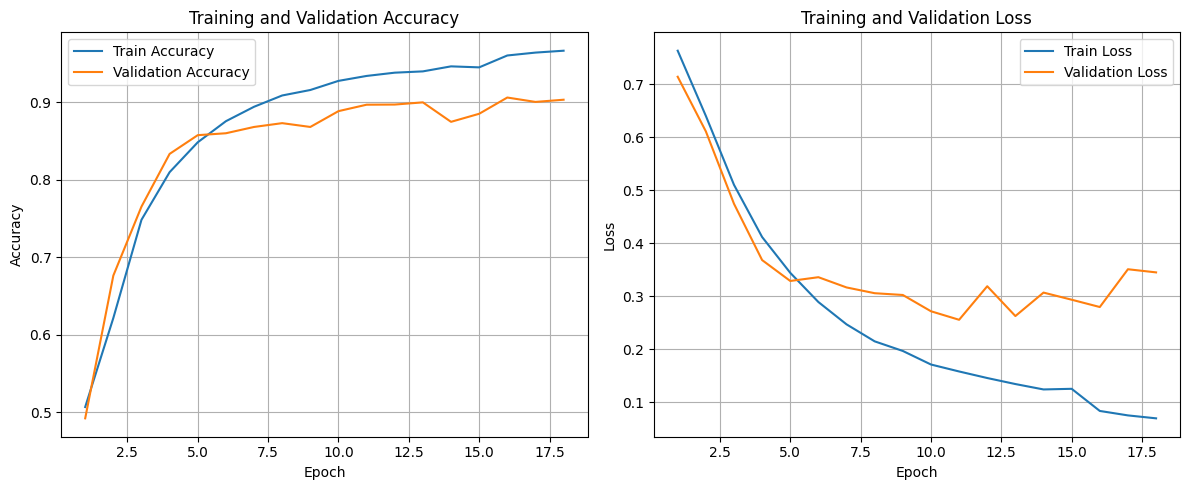

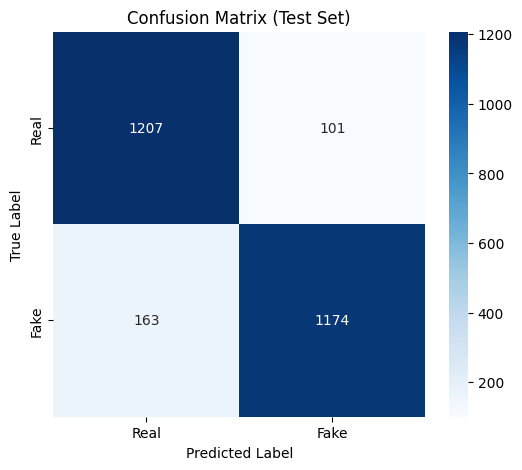

Visualizations generated successfully!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Plotting Accuracy and Loss Curves ---
epochs = range(1, len(history['train_acc']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_acc'], label='Train Accuracy')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Plotting Confusion Matrix ---
plt.figure(figsize=(6, 5))
cm = np.array(test_metrics['confusion_matrix'])
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Real', 'Fake'],
    yticklabels=['Real', 'Fake']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

print("Visualizations generated successfully!")